In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 7,  5, 10,  0,  1,  9,  6,  2,  3]), tensor([8, 4]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[5.5886],
        [6.3542]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.9691]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.8982], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([1.8673], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.8673],
        [1.8673],
        [1.8673],
        [1.8673],
        [1.8673],
        [1.8673],
        [1.8673],
        [1.8673],
        [1.8673],
        [1.8673]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7fa231150510>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.9238]], requires_grad=True),
 Parameter containing:
 tensor([-0.5197], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 180.8143, Validation loss 56.9960
Epoch 1000, Training loss 2.7079, Validation loss 9.4086
Epoch 2000, Training loss 2.1256, Validation loss 8.1890
Epoch 3000, Training loss 2.1155, Validation loss 8.0367

Parameter containing:
tensor([[5.3609]], requires_grad=True)
Parameter containing:
tensor([-16.7552], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 178.4173, Validation loss 60.9054
Epoch 1000, Training loss 2.6008, Validation loss 9.2700
Epoch 2000, Training loss 2.1238, Validation loss 8.1722
Epoch 3000, Training loss 2.1155, Validation loss 8.0345

Parameter containing:
tensor([[5.3616]], requires_grad=True)
Parameter containing:
tensor([-16.7591], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1814], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 187.7910, Validation loss 60.9082
Epoch 1000, Training loss 4.1683, Validation loss 7.7796
Epoch 2000, Training loss 3.8776, Validation loss 13.9341
Epoch 3000, Training loss 2.3478, Validation loss 7.9198
Epoch 4000, Training loss 1.8309, Validation loss 5.4427
Epoch 5000, Training loss 1.6851, Validation loss 4.3936
output tensor([[ 8.0516],
        [12.6177]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [11.]])
hidden tensor([[-0.2316],
        [ 4.5218],
        [-0.3986],
        [-0.2991],
        [ 4.3015],
        [ 0.0158],
        [-2.2370],
        [ 4.6531]])


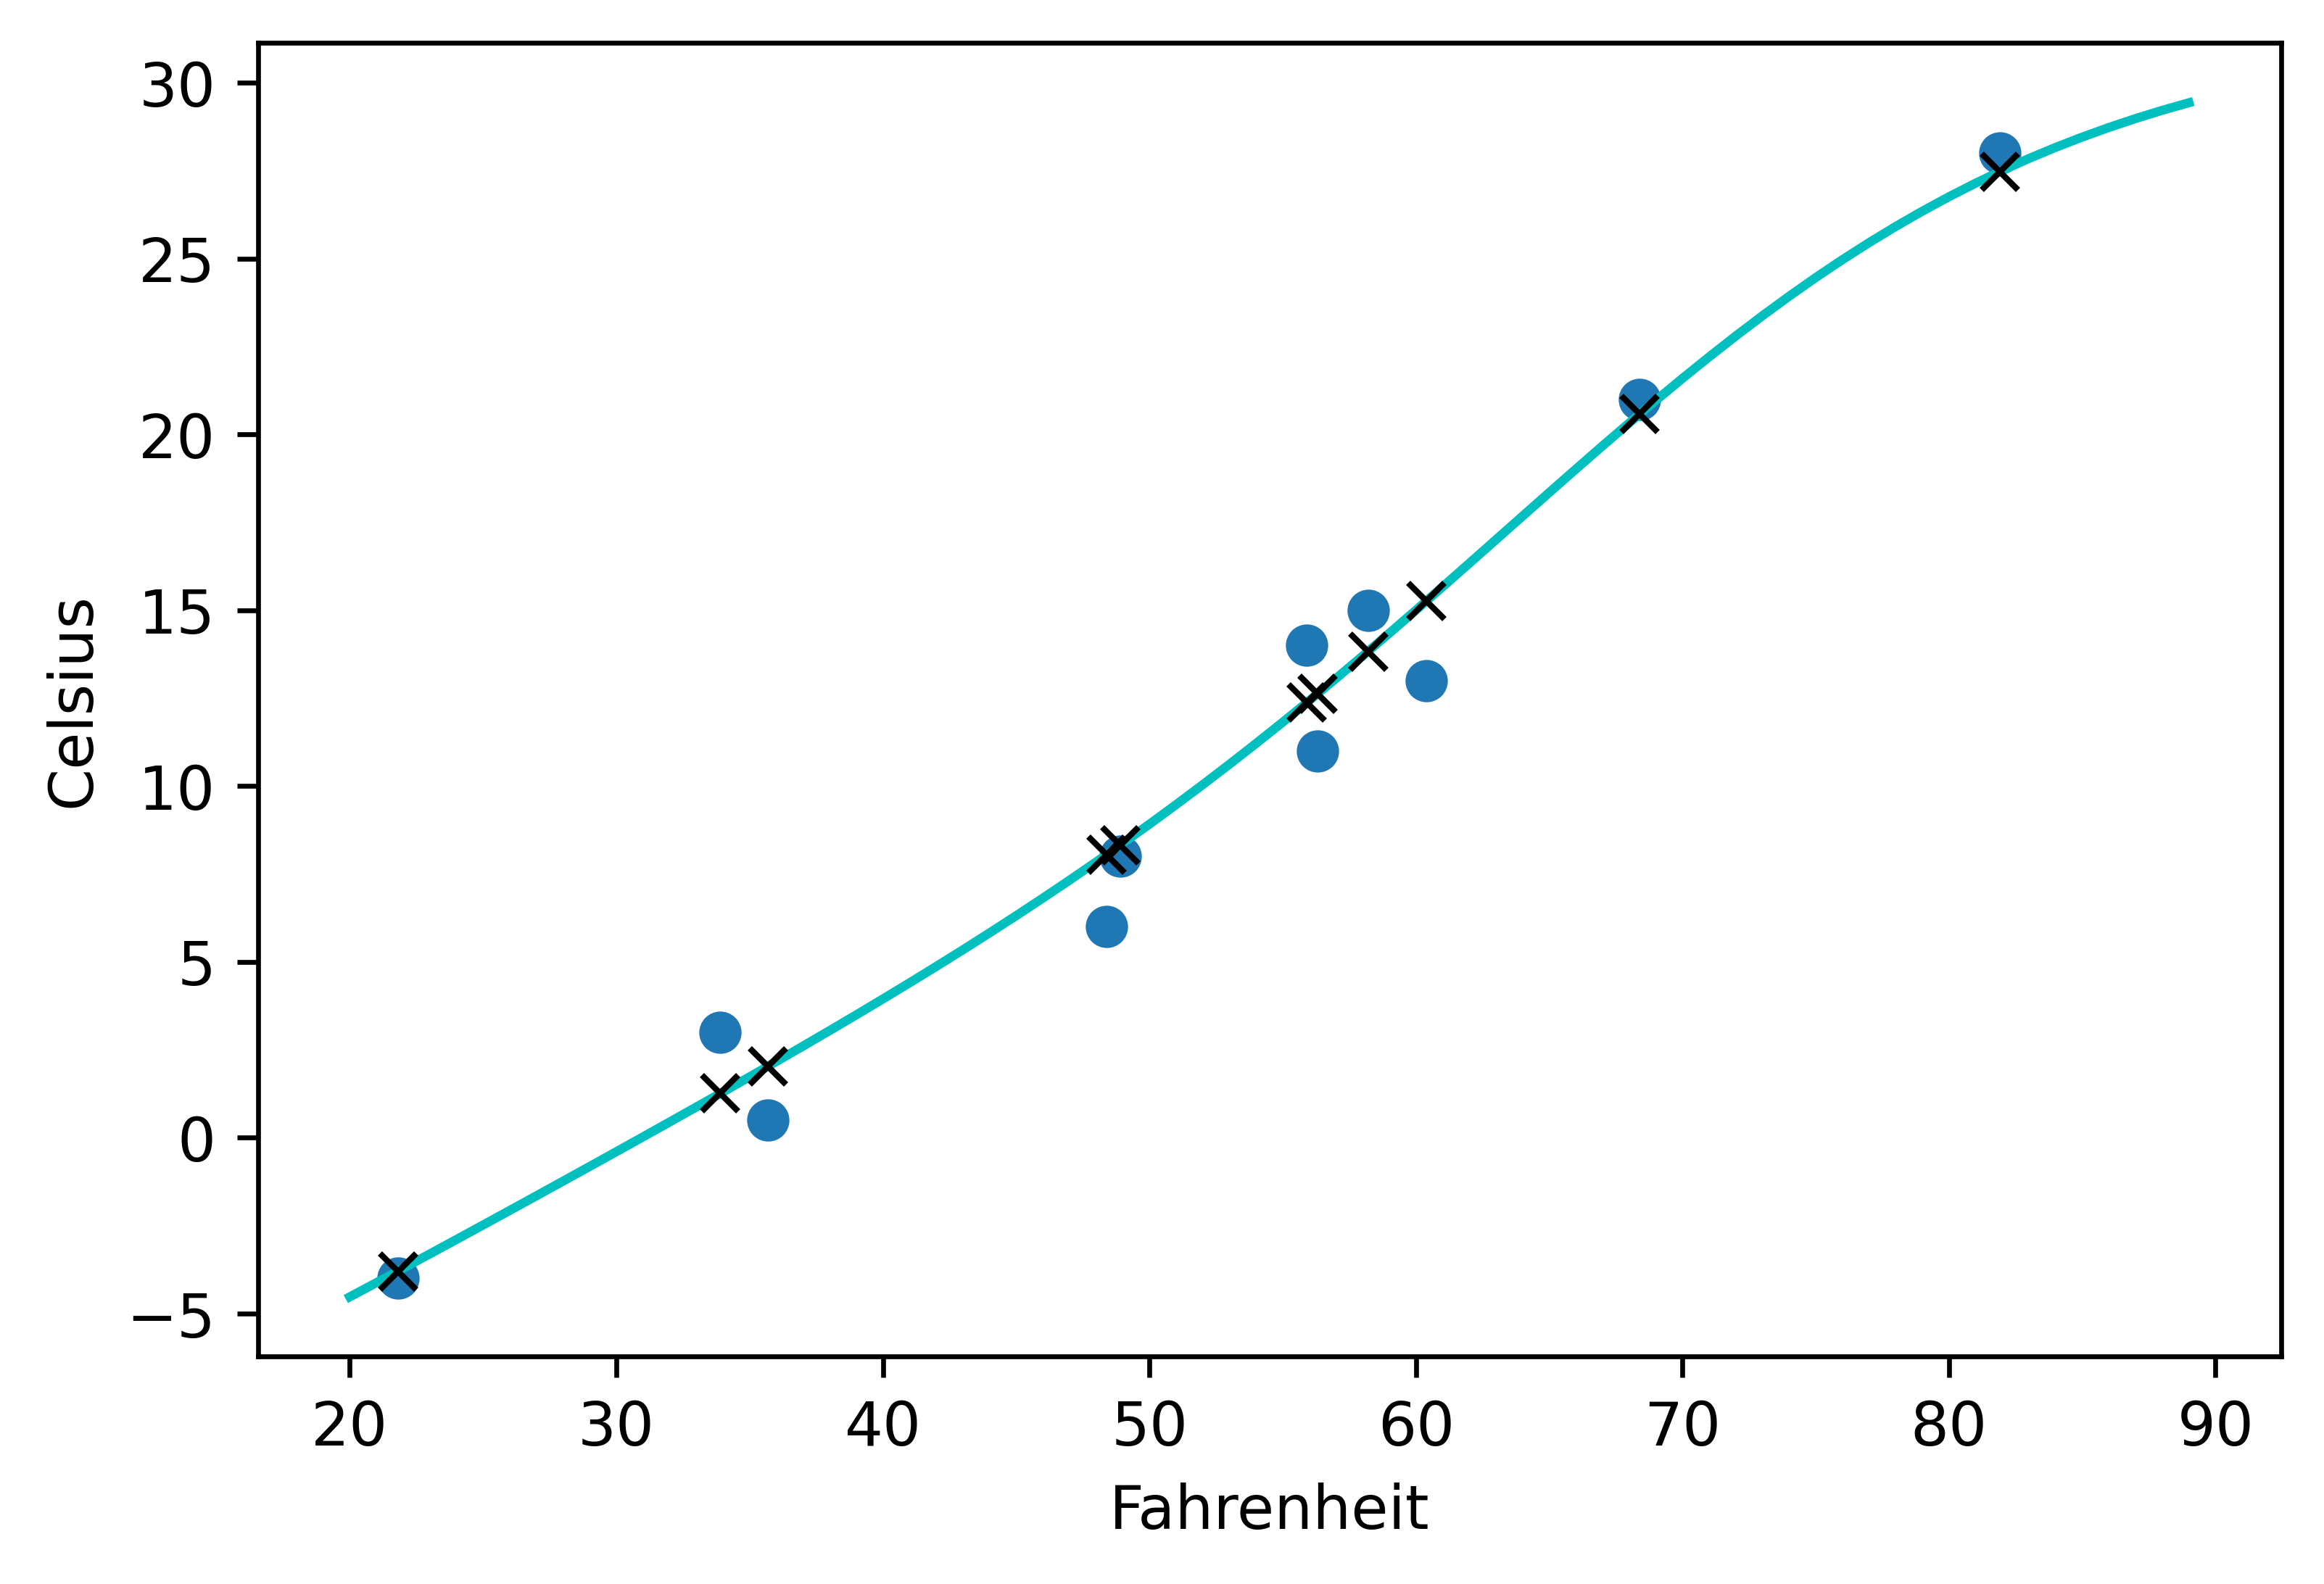

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 209.7419, Validation loss 77.0476
Epoch 1000, Training loss 67.0466, Validation loss 11.4672
Epoch 2000, Training loss 47.2986, Validation loss 13.6049
Epoch 3000, Training loss 25.8151, Validation loss 12.9360
Epoch 4000, Training loss 12.9017, Validation loss 12.0430
Epoch 5000, Training loss 7.4518, Validation loss 11.1761


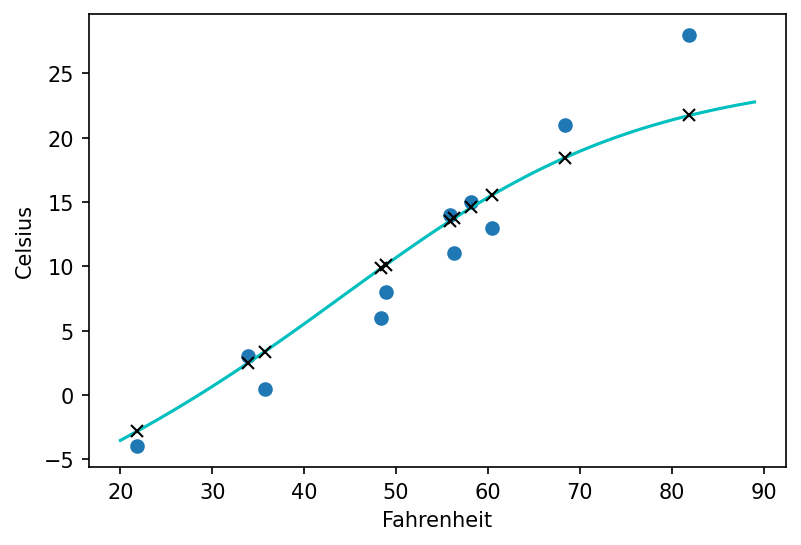

In [24]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
